In [1]:
#Import the basic libraries
import pandas as pd
import numpy as np

#from sklearn.preprocessing import Scaler Methods
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt 
from matplotlib import cm
import itertools
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from sklearn import datasets, metrics
from numpy import nan as NaN

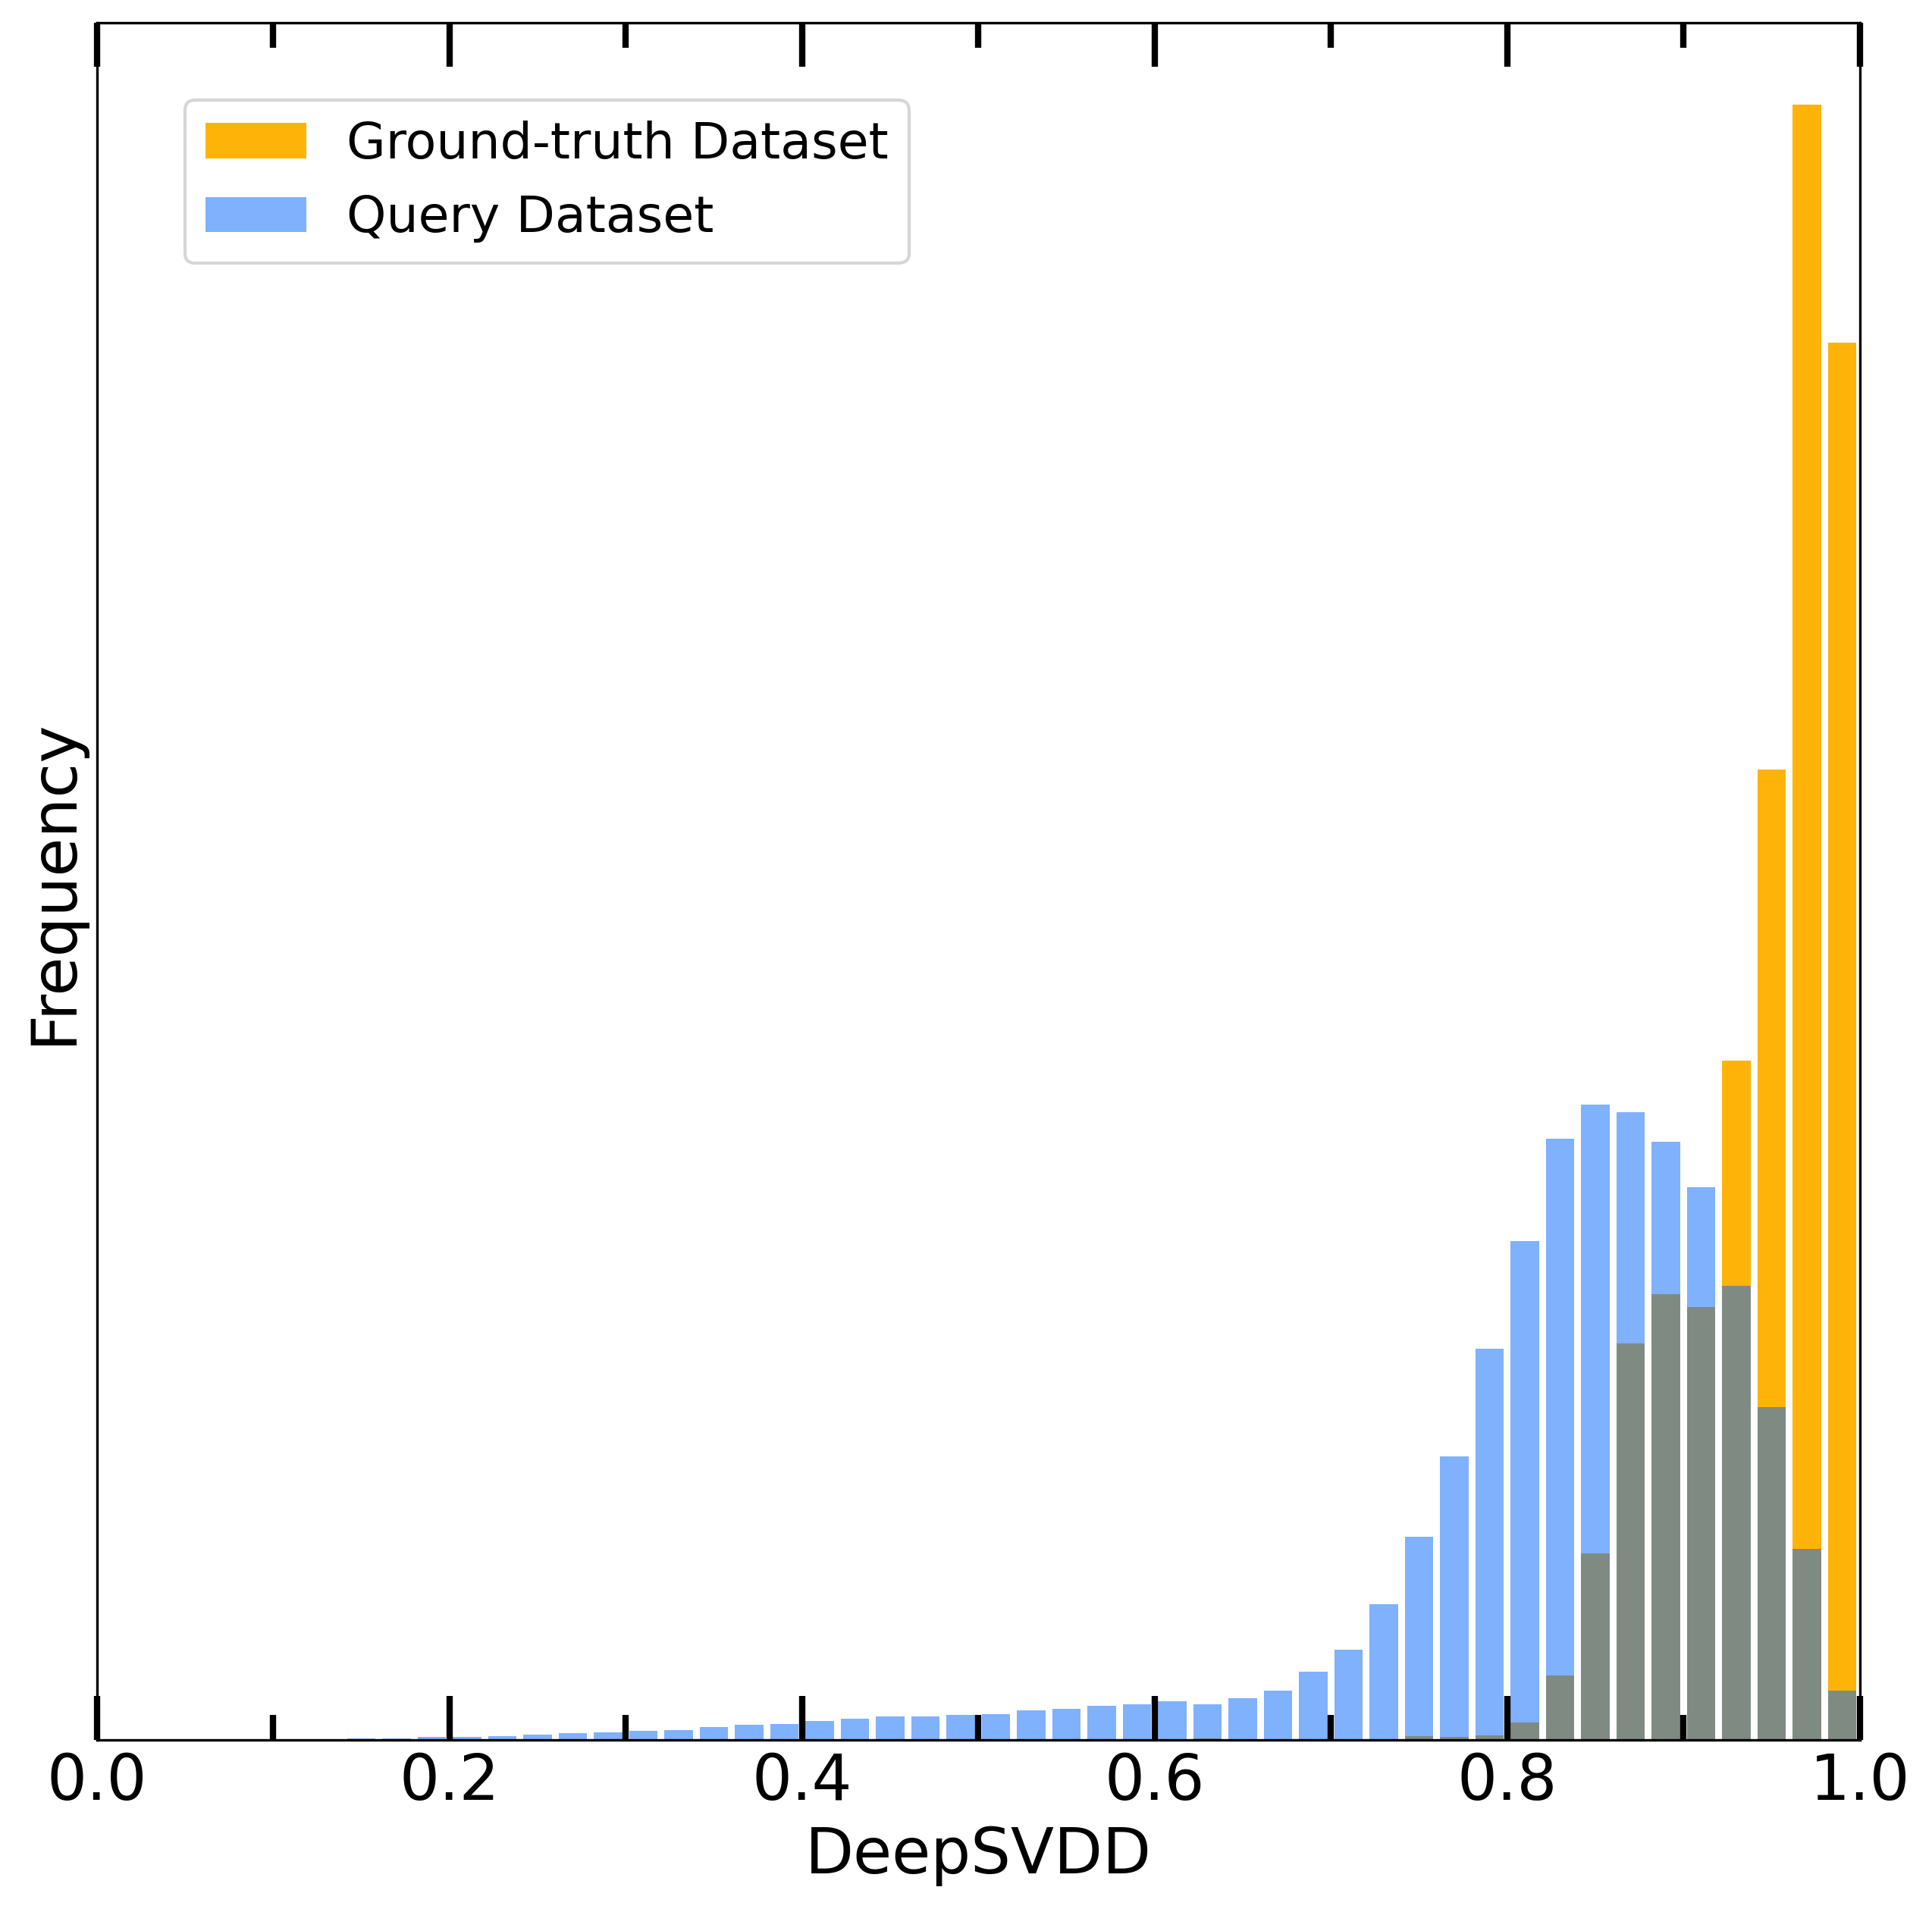

In [31]:
#import results
train_result = pd.read_csv('DeepSVDD_train.csv', index_col=0)
test_result = pd.read_csv('DeepSVDD_test.csv', index_col=0)

MinMax_scaler = preprocessing.MinMaxScaler()

%matplotlib inline
from matplotlib.pyplot import figure
plt.figure(figsize=(10,10),dpi=300)

for i in np.arange(1):
    # score scaler
    scores_range = np.concatenate((train_result.iloc[:,i],test_result.iloc[:,i])).reshape(-1,1)
    scores_scaler = MinMax_scaler.fit(scores_range)
    train_scores = scores_scaler.transform(np.array(train_result.iloc[:,i]).reshape(-1,1)) 
    test_scores = scores_scaler.transform(np.array(test_result.iloc[:,i]).reshape(-1,1))
    scores_bins = scores_scaler.transform(scores_range)
    
    ax = plt.subplot(1,1,i+1)
    _, bins , _ = plt.hist(scores_bins, bins=50, density=True, rwidth=0, alpha=0)
    plt.hist(train_scores, bins=bins, rwidth=0.8, histtype='bar', density=True, alpha=1, color='#feb308', label='Ground-truth Dataset')
    _= plt.hist(test_scores[:], bins=bins, density=True, rwidth=0.8, alpha=0.5, color='#0165fc', label='Query Dataset')
    #_ = plt.axvline(x=threshold, label='Threshold',linestyle='--', c='r', linewidth=3) # threshold line   

    plt.grid(False)
    plt.xlim(0, 1.0)
    plt.xlabel('DeepSVDD', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks([])
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')
    major_ticks_x = np.arange(0, 1.001, 0.2)
    minor_ticks_x = np.arange(0,1.001, 0.1)
    ax.tick_params(axis = 'both', which='both', width=2)
    ax.tick_params(axis = 'both', which='major', length=14)
    ax.tick_params(axis = 'both', which='minor', length=8, color='black')
    ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction="in")
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)

    plt.legend(prop={'size': 16}, loc=[0.05, 0.86])
   
plt.subplots_adjust(wspace=0.1)
plt.show()  

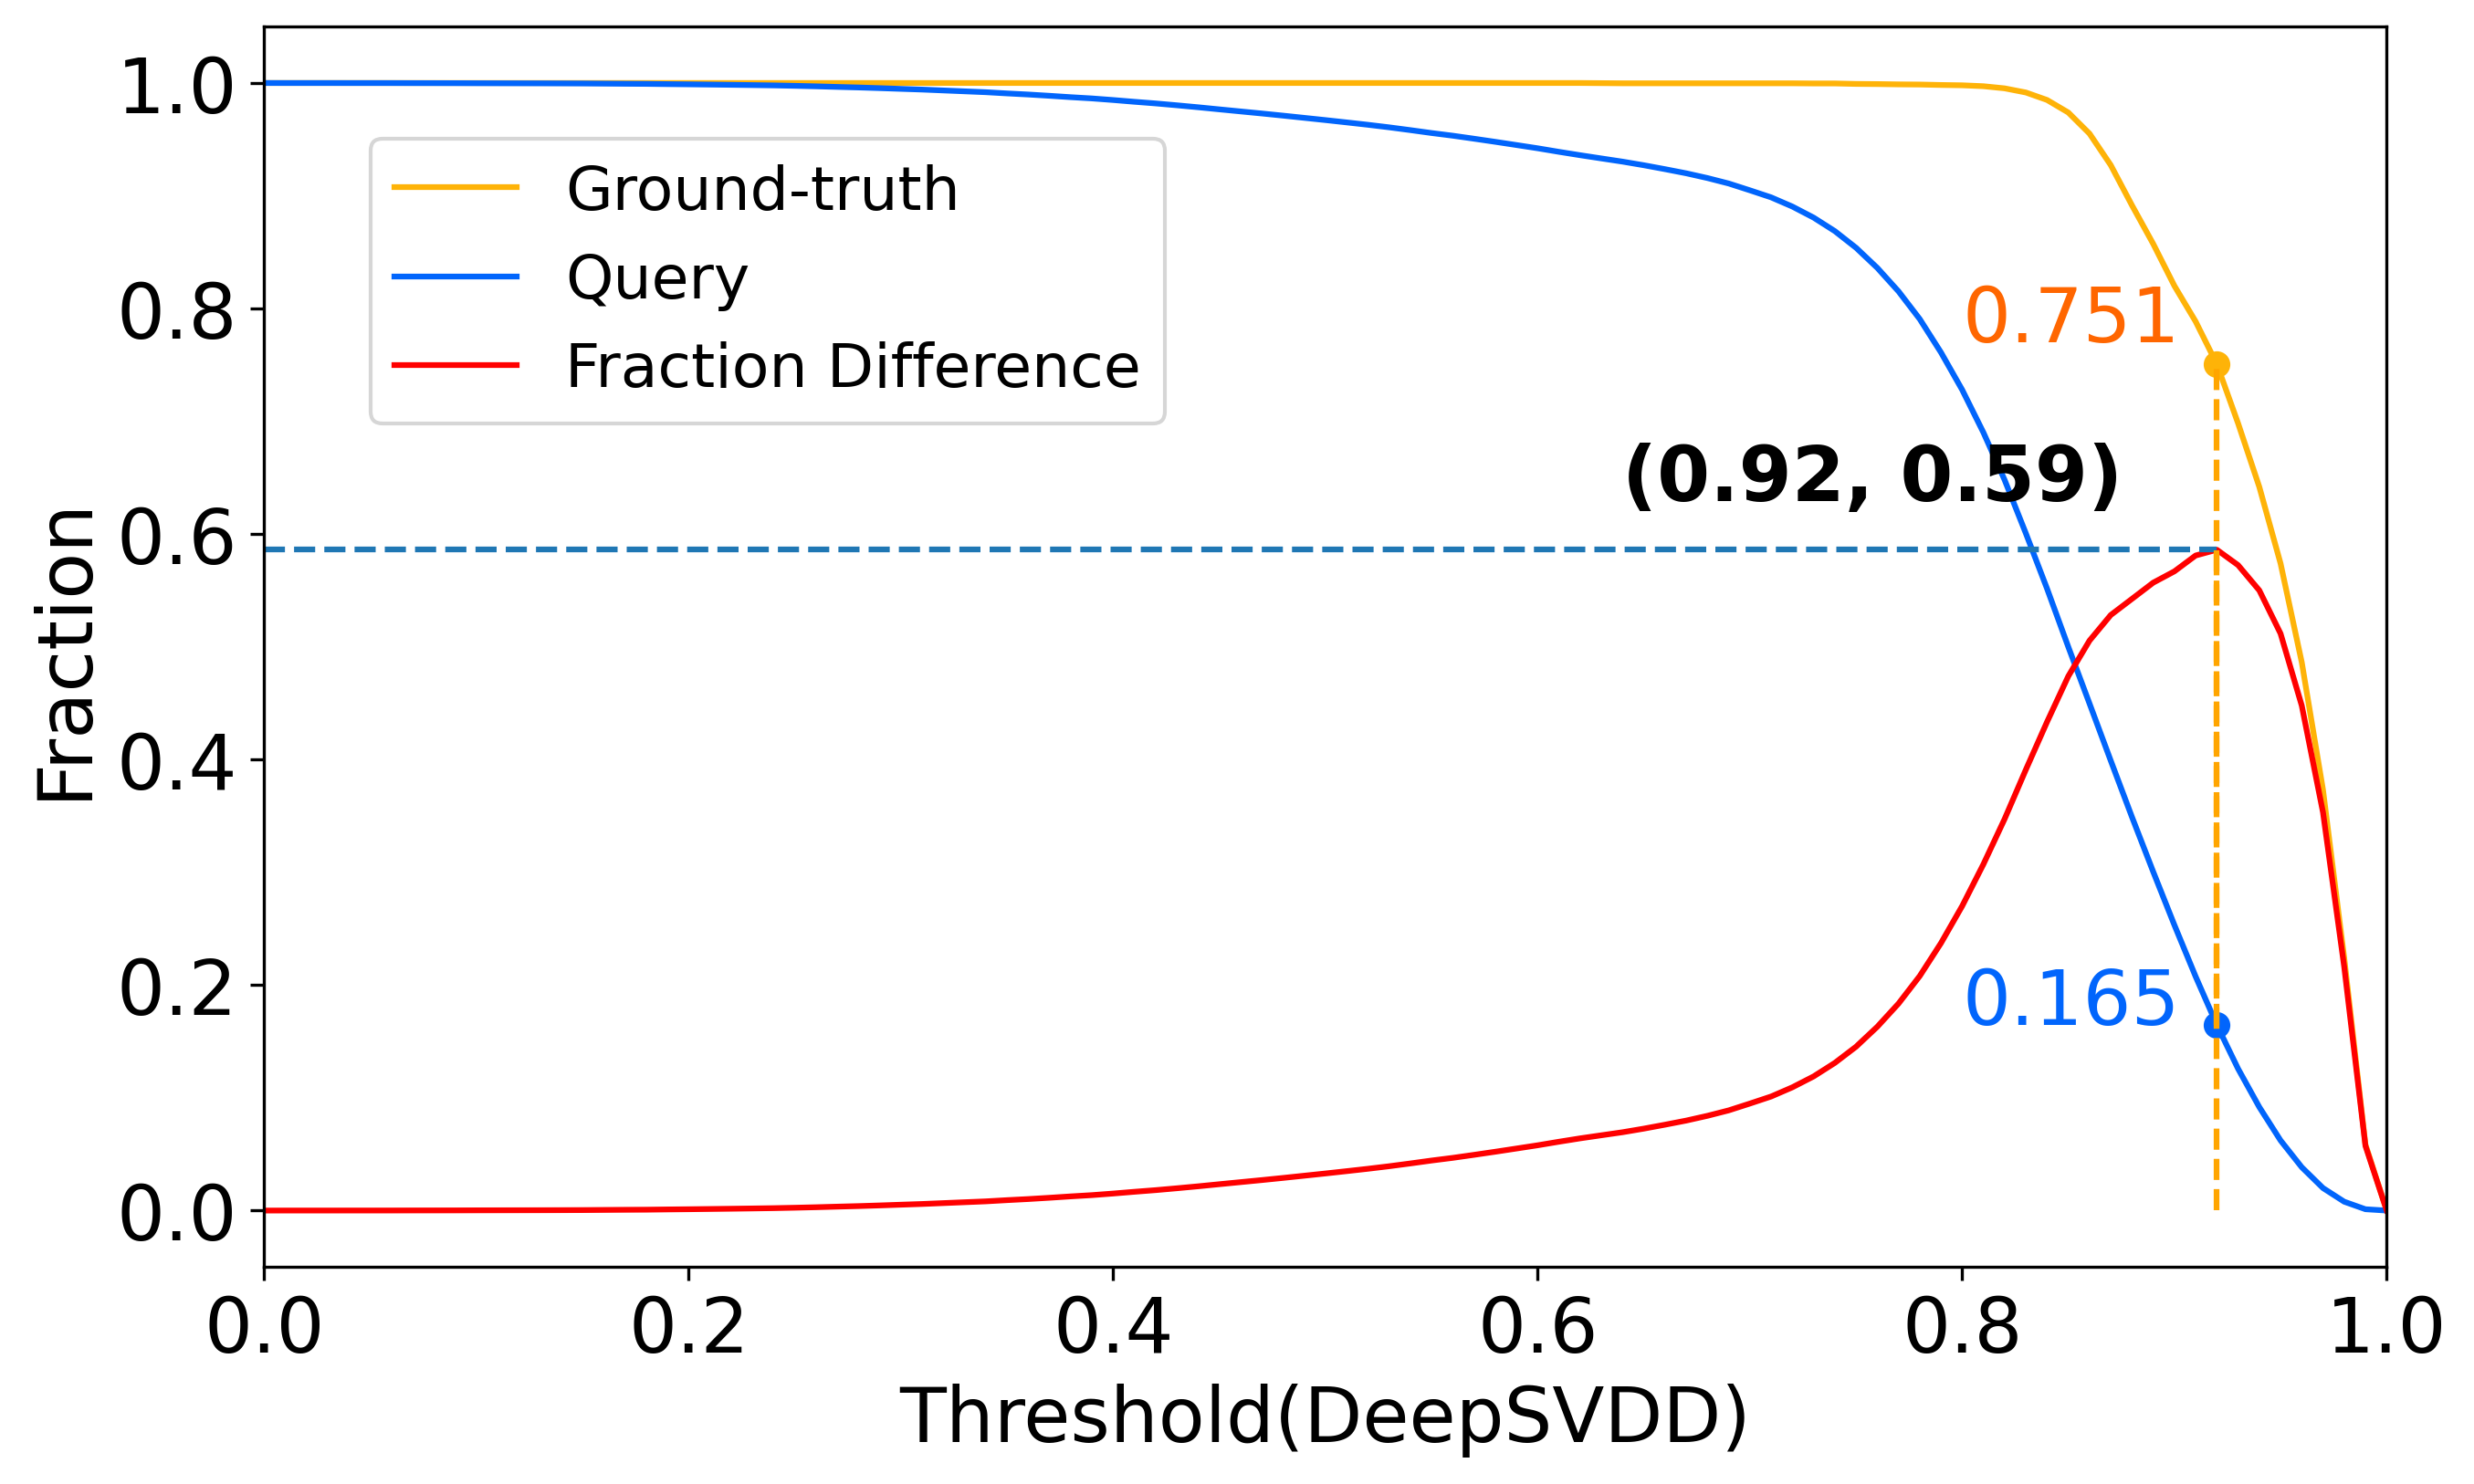

In [33]:
#evaluate
%matplotlib inline
from matplotlib.pyplot import figure
plt.figure(figsize=(10,6),dpi=300)

for i in np.arange(1):
    
    scores_range = np.concatenate((train_result.iloc[:,i],test_result.iloc[:,i])).reshape(-1,1)
    scores_scaler = MinMax_scaler.fit(scores_range)
    train_scores = scores_scaler.transform(np.array(train_result.iloc[:,i]).reshape(-1,1)) 
    test_scores = scores_scaler.transform(np.array(test_result.iloc[:,i]).reshape(-1,1))
    
    ax = plt.subplot(1,1,i+1)
    fontsize = 20
    
    iter_num = np.linspace(0.0,1.0,num=101)
    train_fraction = []
    test_fraction = []
    single_eval = []
    
    for i in iter_num:
        threshold = i
        train_count_inlier = np.sum(train_scores >= threshold)
        test_count_inlier = np.sum(test_scores[:] >= threshold)
        train_percent = train_count_inlier/7375
        test_percent = test_count_inlier/160582
        single = train_percent - test_percent
        train_fraction.append(train_percent)
        test_fraction.append(test_percent)
        single_eval.append(single)

    #plot curves
    plt.plot(iter_num,train_fraction,color='#feb308',label='Ground-truth')
    plt.plot(iter_num,test_fraction,color='#0165fc',label='Query')
    plt.plot(iter_num,single_eval,color='red',label='Fraction Difference')
    
    #extreme point
    single_max = max(single_eval)
    temp = single_eval.index(single_max)
    threshold_max = iter_num[temp]
    plt.plot([0,threshold_max],[single_max,single_max], '--')
    plt.plot([threshold_max,threshold_max],[0,single_max], '--', color='orange')
    single_max = round(single_max,2)
    threshold_max = round(threshold_max,3)
    cord =  '('+format(threshold_max, '.2f')+', '+format(single_max,'.2f')+')'
    plt.text(threshold_max-0.28, single_max+0.04, cord, fontsize=fontsize, fontweight='semibold')
    #test at extreme point
    test_max = test_fraction[temp]
    test_max = round(test_max,3)
    plt.scatter(threshold_max, test_max, c='#0165fc')
    plt.text(threshold_max-0.12, test_max, test_max, fontsize=fontsize,c='#0165fc')
    #train at extreme point
    train_max = train_fraction[temp]
    train_max = round(train_max,3)
    plt.scatter(threshold_max, train_max, c='#feb308')
    plt.text(threshold_max-0.12, train_max+0.02, train_max, fontsize=fontsize,c='#ff6600')
    #draw reference line
    refer_min, refer_max = min(train_max, test_max), max(train_max, test_max)
    plt.plot([threshold_max,threshold_max],[refer_min,refer_max], '--', color='orange')
    
    label = 'Threshold(DeepSVDD)'
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlabel(label, fontsize=fontsize)
    plt.ylabel('Fraction', fontsize=fontsize)
    plt.legend(prop={'size': 16}, loc=[0.05, 0.68])
    plt.xlim(0, 1.0)
    
plt.subplots_adjust(wspace=0.14)    
plt.show()

In [22]:
#a function to calculate the Maximum Fractional Difference (MFD) and the Optimal Threshold (OT) value
def mfd_ot(train_scores, test_scores):
    
    iter_num = np.linspace(0.0,1.0,num=101)
    train_fraction = []
    test_fraction = []
    single_eval = []

    for i in iter_num:
        threshold = i
        train_count_inlier = np.sum(train_scores >= threshold)
        test_count_inlier = np.sum(test_scores[:] >= threshold)
        train_percent = train_count_inlier/len(train_scores)
        test_percent = test_count_inlier/160582
        single = train_percent - test_percent
        train_fraction.append(train_percent)
        test_fraction.append(test_percent)
        single_eval.append(single)

    #extreme point
    single_max = max(single_eval)
    temp = single_eval.index(single_max)
    threshold_max = iter_num[temp]
    
    return threshold_max, single_max

ot, mfd = mfd_ot(train_scores, test_scores)
print(ot, mfd)

0.92 0.5860677142825177


# split validation

In [4]:
#import the result of using only 80% of the ground_truth data to train the model and the remain 20% as a positive validation dataset.
train_result = pd.read_csv('good_train.csv', index_col=0)
test_result = pd.read_csv('good_test.csv', index_col=0)
val_result = pd.read_csv('good_val.csv', index_col=0)

In [28]:
MinMax_scaler = preprocessing.MinMaxScaler()

scores_range = np.concatenate((train_result.iloc[:,0],val_result.iloc[:,0],test_result.iloc[:,0])).reshape(-1,1)
scores_scaler = MinMax_scaler.fit(scores_range)
train_scores = scores_scaler.transform(np.array(train_result.iloc[:,0]).reshape(-1,1)) 
test_scores = scores_scaler.transform(np.array(test_result.iloc[:,0]).reshape(-1,1))
val_scores = scores_scaler.transform(np.array(val_result.iloc[:,0]).reshape(-1,1))

ot, mfd = mfd_ot(train_scores, test_scores)
print(ot, mfd)

train_positive_rate = np.sum(train_scores>=ot)/len(train_scores)
print('np.sum(train_scores>=ot): ', np.sum(train_scores>=ot))
print('len(train_scores): ',len(train_scores))

val_positive_rate = np.sum(val_scores>=ot)/len(val_scores)
print('np.sum(val_scores>=ot): ', np.sum(val_scores>=ot))
print('len(val_scores): ',len(val_scores))

test_positive_rate = np.sum(test_scores>=ot)/len(test_scores)
print('np.sum(test_scores>=ot): ', np.sum(test_scores>=ot))
print('len(test_scores): ',len(test_scores))

print('train_positive_rate: ',train_positive_rate)
print('val_positive_rate: ', val_positive_rate)
print('test_positive_rate: ', test_positive_rate)

0.9500000000000001 0.6055013384576315
np.sum(train_scores>=ot):  4987
len(train_scores):  5900
np.sum(val_scores>=ot):  905
len(val_scores):  1475
np.sum(test_scores>=ot):  38500
len(test_scores):  160582
train_positive_rate:  0.8452542372881356
val_positive_rate:  0.6135593220338983
test_positive_rate:  0.23975289883050405


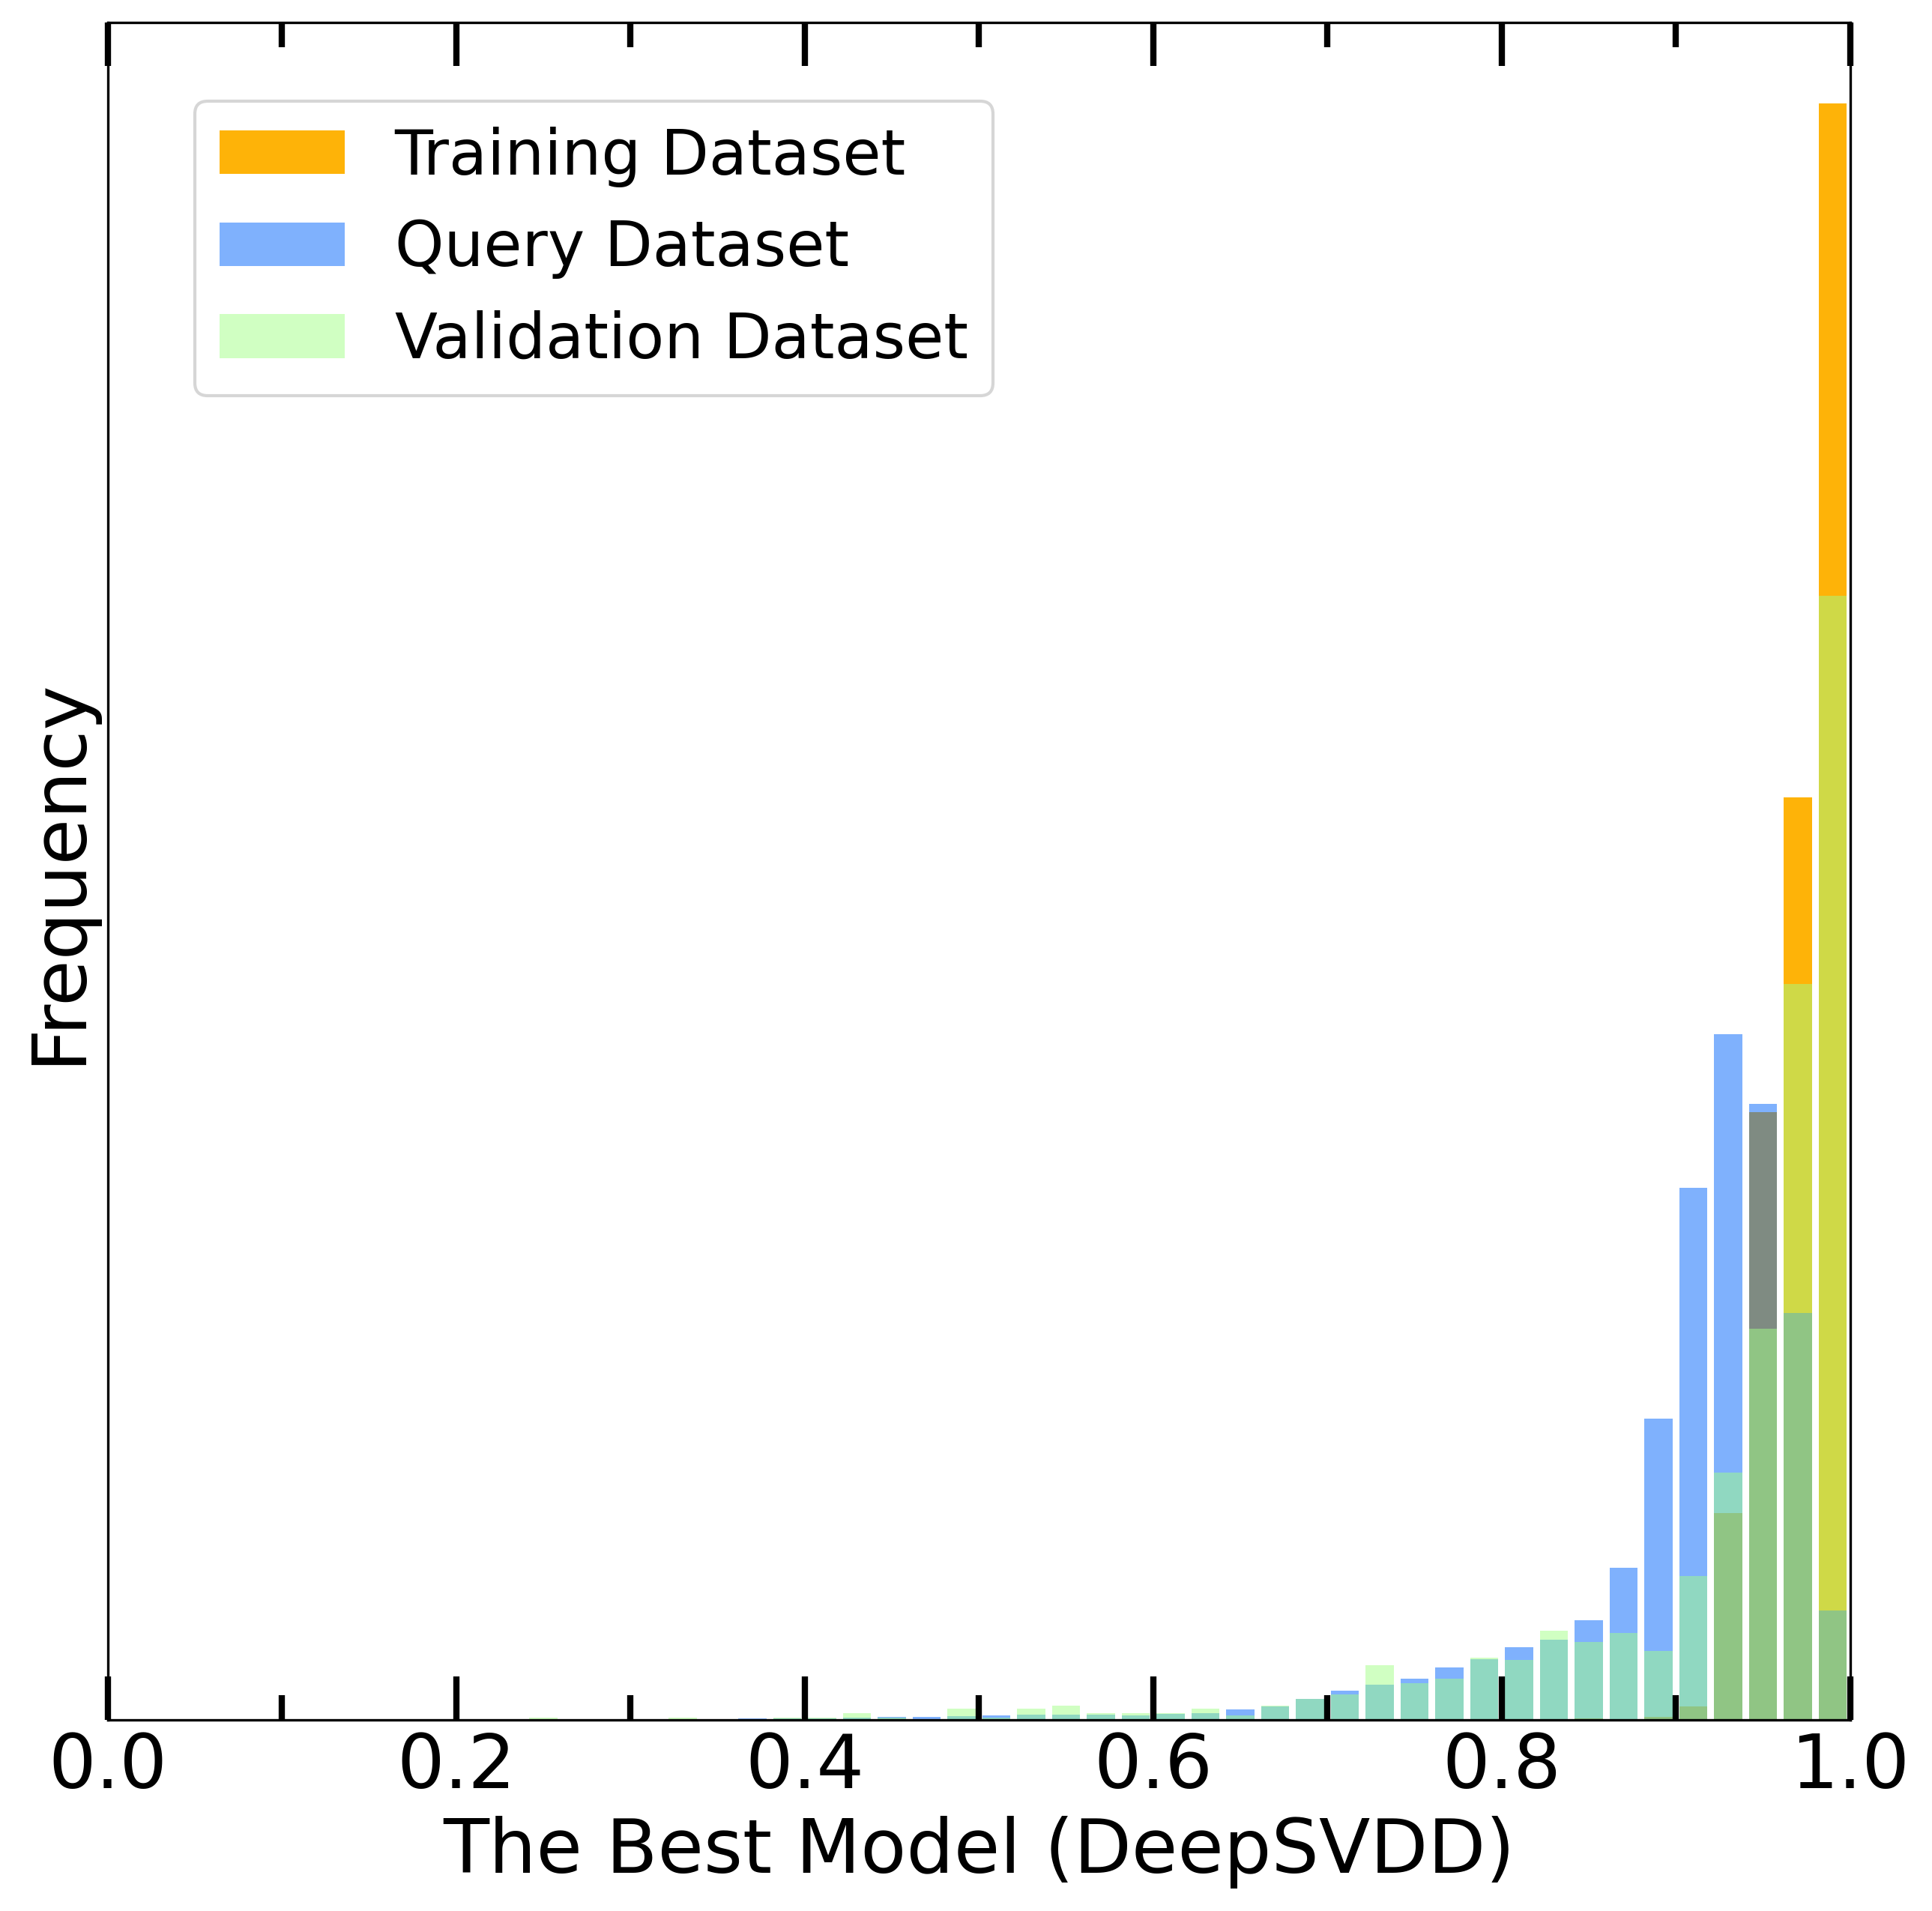

In [29]:
MinMax_scaler = preprocessing.MinMaxScaler()

%matplotlib inline
from matplotlib.pyplot import figure
plt.figure(figsize=(10,10),dpi=300)

scores_range = np.concatenate((train_result.iloc[:,0],val_result.iloc[:,0],test_result.iloc[:,0])).reshape(-1,1)
scores_scaler = MinMax_scaler.fit(scores_range)
train_scores = scores_scaler.transform(np.array(train_result.iloc[:,0]).reshape(-1,1)) 
test_scores = scores_scaler.transform(np.array(test_result.iloc[:,0]).reshape(-1,1))
val_scores = scores_scaler.transform(np.array(val_result.iloc[:,0]).reshape(-1,1))
scores_bins = scores_scaler.transform(scores_range)

ax = plt.subplot(1,1,1)
_, bins , _ = plt.hist(scores_bins, bins=50, density=True, rwidth=0, alpha=0)
plt.hist(train_scores, bins=bins, rwidth=0.8, histtype='bar', density=True, alpha=1, color='#feb308', label='Training Dataset')
_= plt.hist(test_scores, bins=bins, density=True, rwidth=0.8, alpha=0.5, color='#0165fc', label='Query Dataset')
plt.hist(val_scores, bins=bins, density=True, rwidth=0.8, alpha=0.5, color='#A2FF86', label='Validation Dataset')

plt.grid(False)
plt.xlim(0, 1.0)
plt.xlabel('The Best Model (DeepSVDD)', fontsize=24)
plt.ylabel('Frequency', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks([])
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
major_ticks_x = np.arange(0, 1.001, 0.2)
minor_ticks_x = np.arange(0,1.001, 0.1)
ax.tick_params(axis = 'both', which='both', width=2)
ax.tick_params(axis = 'both', which='major', length=14)
ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction="in")
ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)

plt.legend(prop={'size': 20}, loc=[0.05, 0.78])
   
plt.subplots_adjust(wspace=0.1)
plt.show()